In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qibo import models, gates, set_backend
set_backend("numpy")

[Qibo 0.1.15|INFO|2023-07-11 17:58:06]: Using numpy backend on /CPU:0


In [2]:
def plot_amplitudes(amplitudes):
    """Plot amplitudes of the quantum circuit"""
    amplitudes = amplitudes.state()
    states = []
    for i in range(int(len(amplitudes))):
        states.append("{0:0{bits}b}".format(i, bits=int(np.log2(len(amplitudes)/2))))
    fig = plt.figure(figsize = (18,6))
    width = 0.5
    plt.title('Amplitudes', fontdict={'fontsize': 14})
    plt.xlabel('state', fontsize=14)
    plt.ylabel('magnitude', fontsize=14)
    plt.ylim(-1.1,1.1)
    plt.bar(states, np.real(amplitudes), color='C0', width=width)
    plt.xticks(list(range(len(states))), states, rotation=90)
    plt.grid()
    plt.show()
    
def plot_amplitudes_ancilla(amplitudes):
    """Plot amplitudes of the quantum circuit"""
    amplitudes = amplitudes.state()
    states = []
    amp = []
    for i in range(int(len(amplitudes)/2)):
        states.append("{0:0{bits}b}".format(i, bits=int(np.log2(len(amplitudes)/2))))
    for i in range(0, len(amplitudes), 2):
        amp.append((1/np.sqrt(2))*(np.real(amplitudes[i])-np.real(amplitudes[i+1])))
    fig = plt.figure(figsize = (18,6))
    width = 0.5
    plt.title('Amplitudes', fontdict={'fontsize': 14})
    plt.xlabel('state', fontsize=14)
    plt.ylabel('magnitude', fontsize=14)
    plt.ylim(-1.1,1.1)
    plt.bar(states, amp, color='C0', width=width)
    plt.xticks(list(range(len(states))), states, rotation=90)
    plt.grid()
    plt.show()

## Grover's Algorithm

Grover’s algorithm is a **quantum search algorithm** that can search for a value or element
in an unsorted set in $\mathcal{O}(\sqrt{N})$ as opposed to classical search algorithms that at worst
will find an element in $\mathcal{O}(N)$ time.

The problem is formulated as follows:

### Problem formulation
Suppose that we are given a Boolean function
$$ f : \{ 0,1 \}^n \rightarrow  \{ 0,1 \}$$
and we wish to determine a bitstring $x$ such that $f(x) = 1$.

*Basically we want to search a specific bitstring in the ensemble for all possible bistrings.*

We can model this situation by sypposing that have the following black box:

$$ f_w (x) = \begin{cases} 0 \quad x \neq w \\ 1 \quad x = w\end{cases}$$ 

where $x \in \{ 0,1,2, \dots, N-1\} $ for some unknown $w$.


How many times do we need to query the box classically to find $w$?

*Put your answer here*

We will show that with Grover's algorithm it is possible to find the solution in $\mathcal{O}(\sqrt{N})$.

### Grover explanation

Suppose that we have a quantum **oracle** with the ability to *recognize* the element $w$. To be able to show the solution
in QC we often use ancilla/oracle qubits. A general oracle can be written as an unitary operator $O$ acting in the following way:

$$\ket{x}\ket{q} \rightarrow \ket{x}\ket{q \oplus f_w(x)}$$
where $\ket{x}$ is the index register and $\ket{q}$ is the oracle qubit.
From the previous Eq. we can see how the sign of $\ket{q}$ is flipped if $f(x) = 1$. In fact:
$$ \ket{x}\ket{q \oplus f_w(w)} = \ket{x}\ket{q \oplus 1} = - \ket{x}\ket{q}$$
while if $x$ is not the solution we get the same state:
$$  \ket{x}\ket{q \oplus f_w(x)} = \ket{x}\ket{q \oplus 0} = \ket{x}\ket{q} $$



### Procedure

The first step of Grover's algorithm is to prepare the uniform superposition of all values of $x$.

In [3]:
def create_superposition(nqubits):
    """Create circuit for superposition"""
    superposition = models.Circuit(nqubits)
    superposition.add([gates.H(i) for i in range(nqubits)])

    return superposition

As we can see now all bistrings have equal probabilities of being sampled:

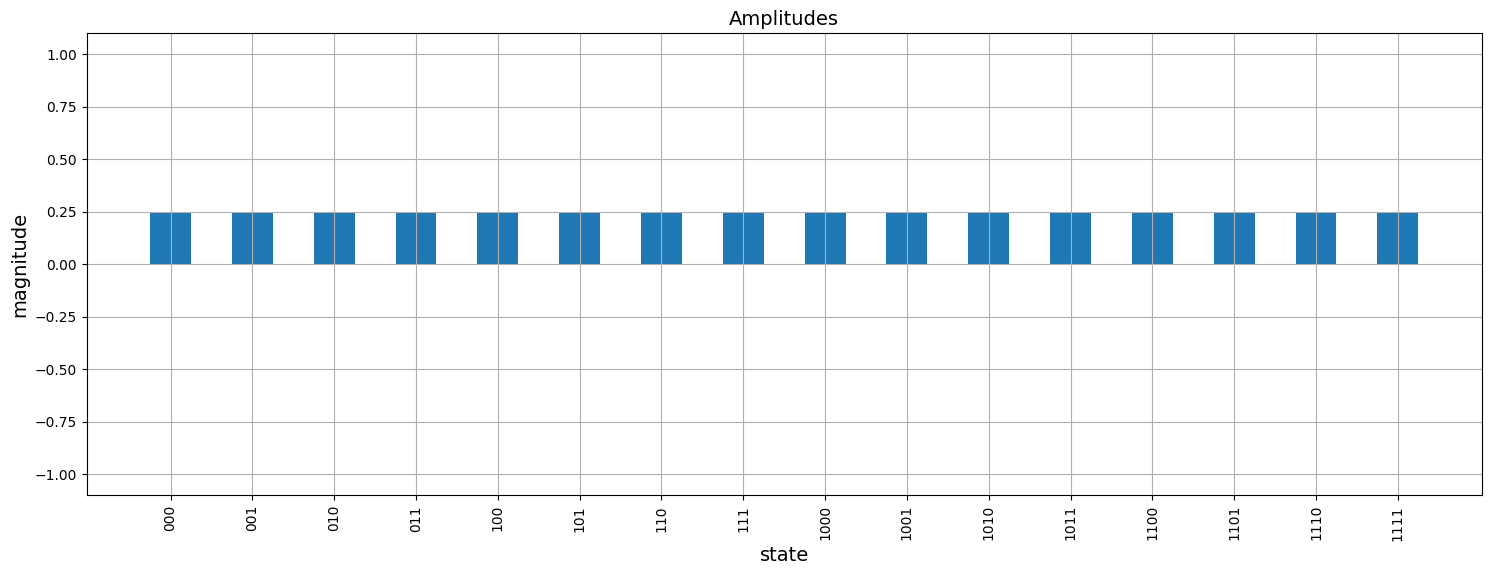

In [4]:
nqubits = 4
superposition = create_superposition(nqubits)
result = superposition()
plot_amplitudes(result)


Grover's algorithm aims at finding the marked state by increasing its amplitude while suppressing the others.
The amplitude is increased sequentially by applying iteratively the Grover operator $G$ which is defined in the following way:

$$ G_w = O_w D$$
where $O$ is the oracle and $D$ is the diffuser.

### The oracle $O$
The oracle is the operator that changes the sign of the amplitudes of the quantum states that encode solutions of the problem.
As we saw before it corresponds to the following operation:
$$O: \ket{x}\ket{q} \rightarrow \ket{x}\ket{q \oplus f_w(x)}$$

By choosing $\ket{-}=\frac{\ket{0}-\ket{1}}{\sqrt{2}}$ as the initial state for the ancilla qubit we can rewrite the oracle as a *phase oracle*
$$O_w: \ket{x}\ket{-} \rightarrow (-)^{f_w(x)}\ket{x}\ket{-}$$


Which can be expressed as the following (ignoring the output register which remains $\ket{-}$):

$$ O_w = I - 2 \ket{w} \bra{w}$$
which is exactly the operator which flips $\ket{w}$.


### Exercise:
Code the oracle circuit.

*Hint start with a fixed number of qubits and a specific $w$* then generalize to arbitrary $w$ and arbitrary number of qubits.

In [5]:
def create_oracle(state):
    """Oracle"""
    nqubits = len(state)
    oracle = models.Circuit(nqubits+1)
    oracle.add(gates.X(nqubits))
    oracle.add(gates.H(nqubits))
    index = [i for i,value in enumerate(list(state)) if value == '0']
    oracle.add([gates.X(i) for i in index])
    oracle.add(gates.X(nqubits).controlled_by(*range(nqubits)))
    oracle.add([gates.X(i) for i in index])

    return oracle

Note the use of `gate.controlled_by` method which allows to control any gate to an arbitrary number of qubits

In [6]:
oracle = create_oracle('0101')
print(oracle.draw())

q0: ─X───o─X─
q1: ─────o───
q2: ─X───o─X─
q3: ─────o───
q4: ─X─H─X───


Lets check again the final amplitudes after creating the superposition and applying the oracle. 

First we create the total circuit

q0: ─H─X─o─X─
q1: ─H───o───
q2: ─H─X─o─X─
q3: ─H───o───
q4: ─X─H─X───


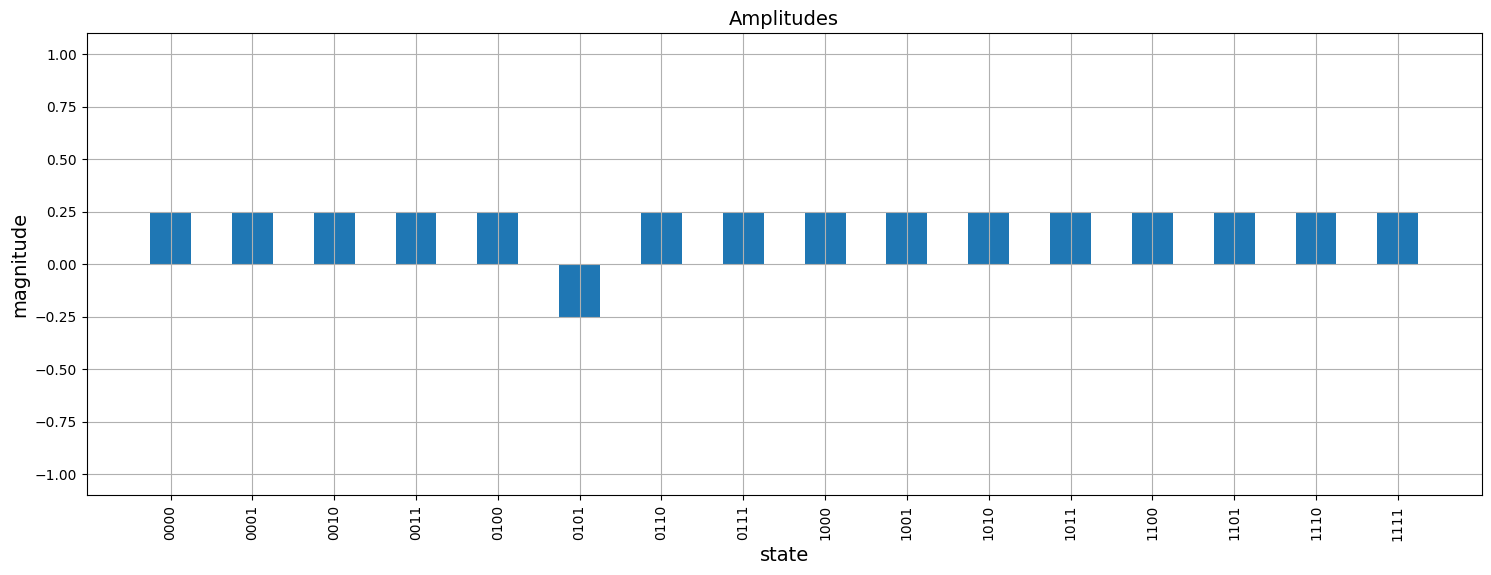

In [7]:
circuit = models.Circuit(nqubits+1)
circuit.add(superposition.on_qubits(*range(nqubits)))
circuit += oracle
print(circuit.draw())
result = circuit()
plot_amplitudes_ancilla(result)

Notice how the oracle inverted the sign of the amplitude of the target state.

### The diffuser $D$

The diffuser increase the amplitude of the marked state while lowering the other ones.
Mathematically corresponds to the following operator:

$$D = 2 \ket{s} \bra{s} - I$$
where $\ket{s} = H^{\otimes n} \ket{0}$.



### Exercise

Implement the $D$ operator.

*Hint: $D$ can be decomposed in the following way:*
$$ D = H^{\otimes n} CPS_0 H^{\otimes n}$$
*where $CPS_0$ is a conditional phase shift that flips the sign of all amplitudes but the state $\ket{0}$*
$$ CPS_0 \ket{x} \rightarrow - (-)^{\delta_{x0}} \ket{x} $$ 

In [8]:
def create_diffuser(nqubits):
    diffuser = models.Circuit(nqubits)
    for i in range(nqubits):
        diffuser.add(gates.H(i))
    for i in range(nqubits):
        diffuser.add(gates.X(i))
    diffuser.add(gates.Z(0).controlled_by(*range(1,nqubits)))
    for i in range(nqubits):
        diffuser.add(gates.X(i))
    for i in range(nqubits):
        diffuser.add(gates.H(i))
    return diffuser

Let's check the amplitudes after the diffusion using the same methods as above

In [9]:
diffuser = create_diffuser(nqubits)
print(diffuser.draw())
grover = models.Circuit(nqubits+1)
grover.add(superposition.on_qubits(*range(nqubits)))
grover += create_oracle('0101')
grover.add(diffuser.on_qubits(*range(nqubits)))
print(grover.draw())

q0: ─H─X─Z─X─H─
q1: ─H─X─o─X─H─
q2: ─H─X─o─X─H─
q3: ─H─X─o─X─H─
q0: ─H─X─o─X─H─X─Z─X─H─
q1: ─H───o─H─X───o─X─H─
q2: ─H─X─o─X─H─X─o─X─H─
q3: ─H───o─H─X───o─X─H─
q4: ─X─H─X─────────────


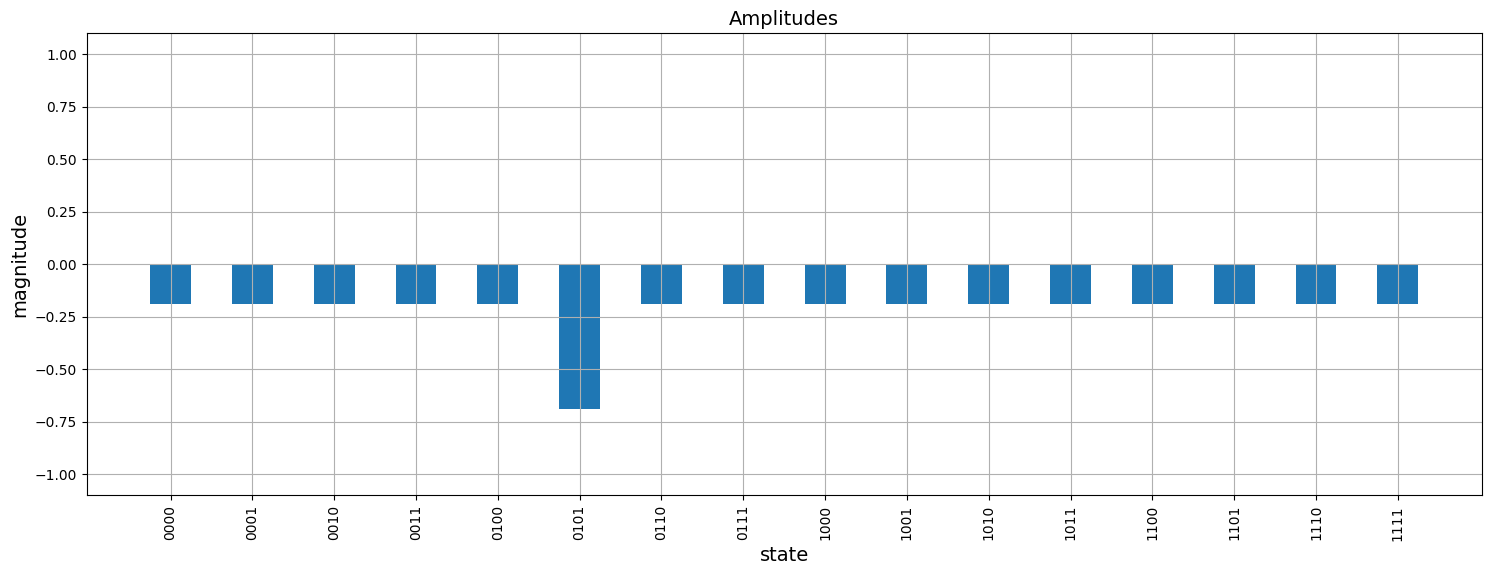

In [10]:
result = grover()
plot_amplitudes_ancilla(result)

Notice how the diffuser increased the amplitude of the target state.

### Grover's algorithm

By combining all the previous elements we can construct the full Grover's algorithm

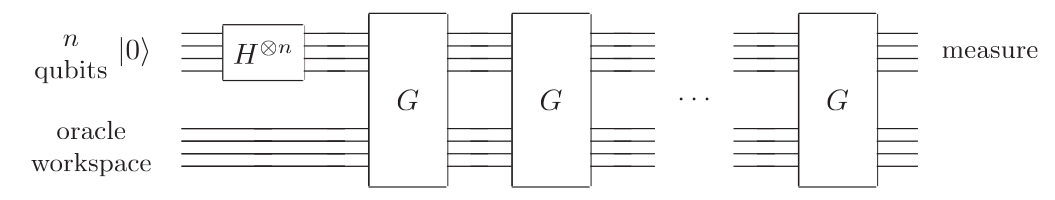

### Exercise: implement Grover's algorithm

In [11]:
def create_grover(state, iterations):
    """Complete circuit that implements Grover's algorithm.
    
    Args:
        state (str): Target state.
        iterations (int): Number of times the oracle + diffuser operation is repeated.
    """
    nqubits = len(state)
    superposition = create_superposition(nqubits)
    oracle = create_oracle(state)
    diffuser = create_diffuser(nqubits)
    
    grover = models.Circuit(nqubits+1)
    grover.add(superposition.on_qubits(*range(nqubits)))
    for _ in range(iterations):
        grover += oracle
        grover.add(diffuser.on_qubits(*range(nqubits)))
    # measure all qubits
    grover.add([ gates.M(i) for i in range(nqubits)])
    return grover

You can check how the amplitude is affected by changing the number of iterations below

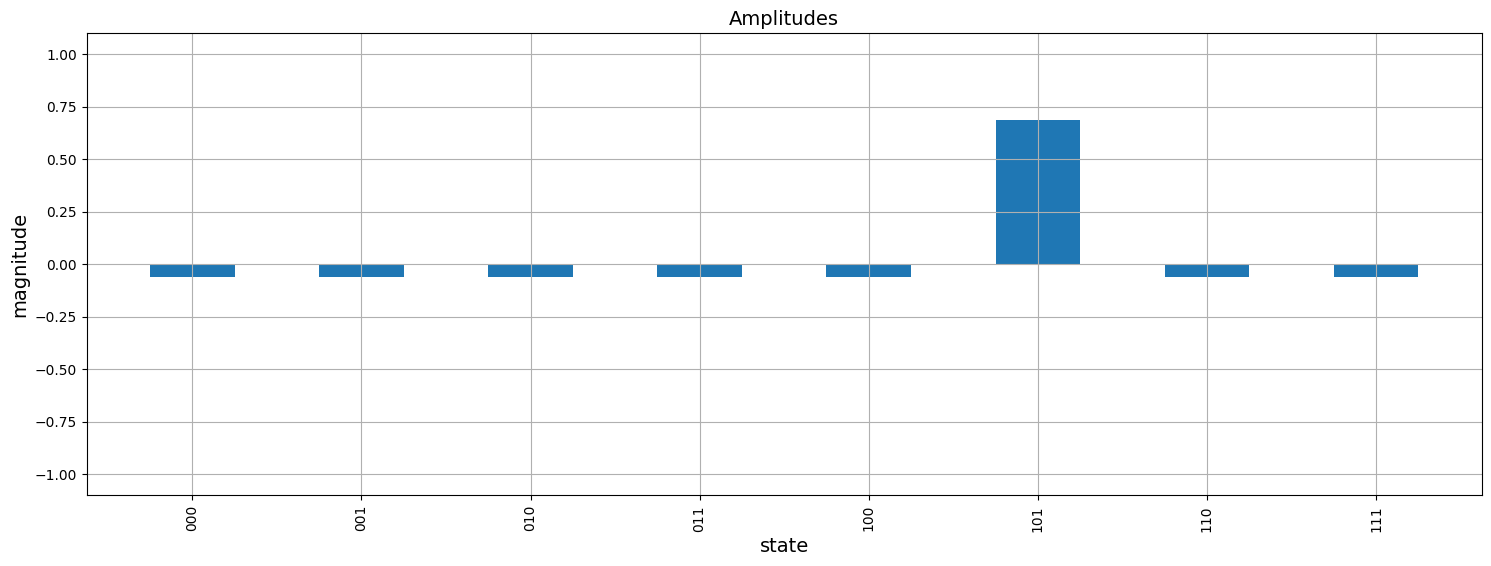

In [12]:
grover = create_grover('101', 2)
plot_amplitudes_ancilla(grover())

The number of iterations that gives the highest probability is given by

$$ \frac{\pi }{4}\sqrt{\frac{2^{n_{qubits}}}{n_{solutions}}} $$

where $n_{solutions}$ is the number of target solutions to the search. In our case $n_{solutions} = 1$.

ADD REF

In [13]:
def grover_iterations(nqubits, nsol=1):
    return int((np.pi/4)*np.sqrt((2**nqubits)/nsol))

In [14]:
iterations = grover_iterations(3)
iterations

2

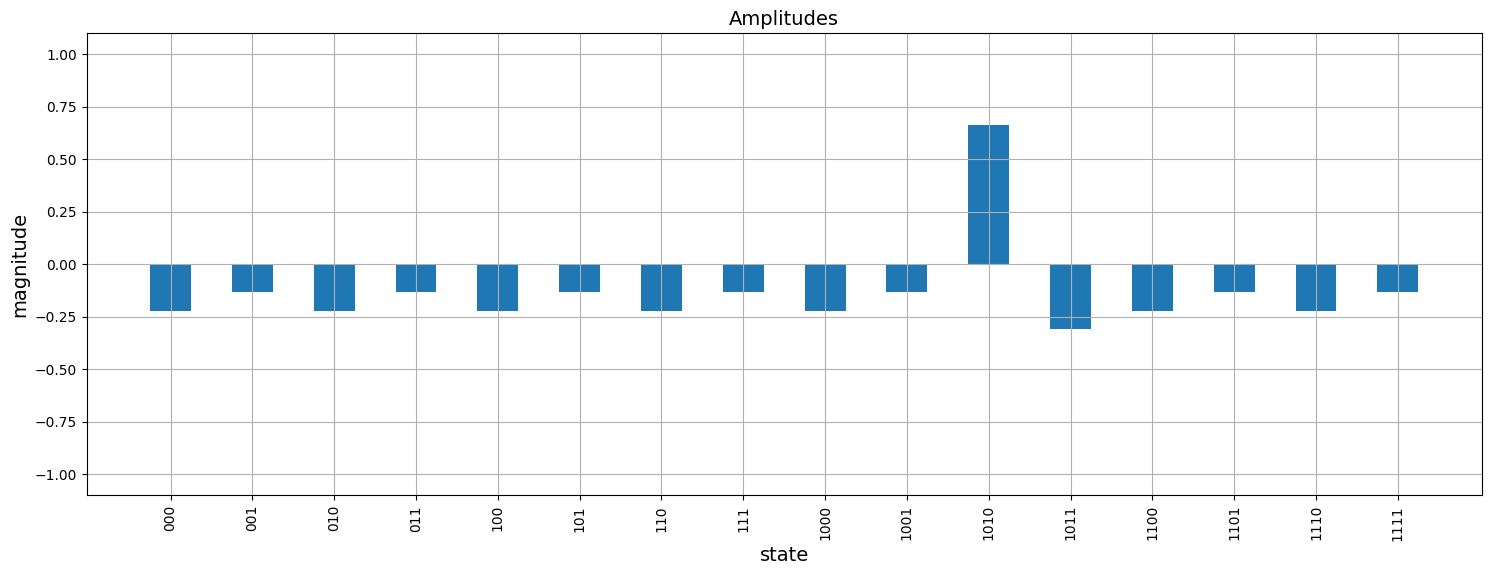

In [15]:
grover = create_grover('101', iterations)
plot_amplitudes(grover())

We can also have a look at the frequencies of measuring each bitstring

In [16]:
result = grover(nshots=1000)
result.frequencies()

Counter({'101': 485,
         '011': 83,
         '000': 82,
         '010': 81,
         '001': 75,
         '110': 73,
         '100': 68,
         '111': 53})

## Let's try to run the Grover's algorithm with an increasing number of qubits?

How does the perfomance decreases computation wise with a large number of qubits?

In [42]:
import time

def performance(backend, platform=None, qubit_range=range(4,15)):
    set_backend(backend)
    times = []
    for i in qubit_range:
        iterations = grover_iterations(i,1)
        print("nqubits", i, end="")
        state = "1" * i
        circuit = create_grover(state, iterations)
        start = time.time()
        result = circuit(nshots=1000)
        end = time.time()
        print(f"\tTime = {end-start}")
        # Frequency of the target bitstring
        freq = result.frequencies().get(i * '1')
        print("Frequency =", freq)
        times.append(end-start)
    
    return times, list(qubit_range)

def plot_times(qubits, times, title="numpy"):
    plt.plot(qubits, times, label=title)
    plt.xlabel('Number of qubits', fontsize=14)
    plt.ylabel('Time (s)', fontsize=14)
    plt.legend()
    
        

In [46]:
times, qubits = performance("numpy", range(4,20))

[Qibo 0.1.15|INFO|2023-07-11 18:09:03]: Using numpy backend on /CPU:0


nqubits 4	Time = 0.0014607906341552734
Frequency = 149
nqubits 5	Time = 0.0018513202667236328
Frequency = 23
nqubits 6	Time = 0.0029442310333251953
Frequency = 69
nqubits 7	Time = 0.005987405776977539
Frequency = 9
nqubits 8	Time = 0.009492158889770508
Frequency = 2
nqubits 9	Time = 0.011801004409790039
Frequency = 24
nqubits 10	Time = 0.02914571762084961
Frequency = 7
nqubits 11	Time = 0.07482719421386719
Frequency = 2
nqubits 12	Time = 0.18314433097839355
Frequency = 1
nqubits 13	Time = 0.512152910232544
Frequency = None
nqubits 14	Time = 1.453841209411621
Frequency = None


In [47]:
times_qibojit, _ =performance("qibojit", "numba", range(4,20))

[Qibo 0.1.15|INFO|2023-07-11 18:09:07]: Using qibojit (numba) backend on /CPU:0


nqubits 4	Time = 0.01899552345275879
Frequency = 126
nqubits 5	Time = 0.0011663436889648438
Frequency = 13
nqubits 6	Time = 0.0020265579223632812
Frequency = 57
nqubits 7	Time = 0.037418365478515625
Frequency = 10
nqubits 8	Time = 0.019992828369140625
Frequency = 1
nqubits 9	Time = 0.025490999221801758
Frequency = 22
nqubits 10	Time = 0.01992940902709961
Frequency = 15
nqubits 11	Time = 0.037284135818481445
Frequency = 4
nqubits 12	Time = 0.06251120567321777
Frequency = 1
nqubits 13	Time = 0.12681221961975098
Frequency = None
nqubits 14	Time = 0.17412090301513672
Frequency = None
nqubits 15	Time = 0.5627834796905518
Frequency = None
nqubits 16	Time = 1.4855551719665527
Frequency = None
nqubits 17	Time = 10.109002590179443
Frequency = None
nqubits 18	Time = 19.143168926239014
Frequency = None
nqubits 19	Time = 62.76249957084656
Frequency = None


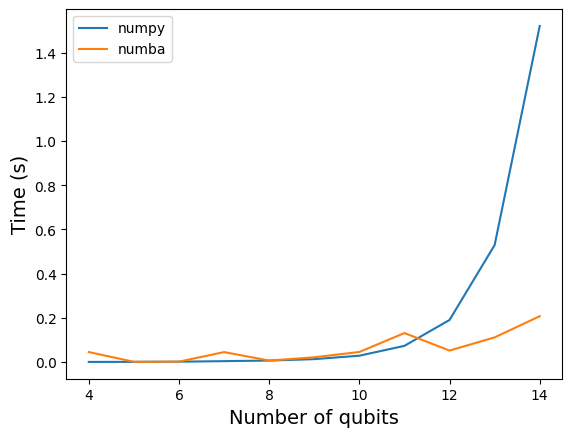

In [45]:
plot_times(qubits, times,"numpy")
plot_times(qubits, times_qibojit, "numba")
